In [244]:
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

In [241]:
def get_datetime(time_stamp):
    date = datetime.datetime.strptime(time_stamp,'%Y-%m-%d %H:%M:%S')
    weekday = date.weekday()
    hour = date.hour + date.minute/60
    return weekday,hour

def prepare_data():
    with open('TiktokData.json','r') as json_file:
        json_list = list(json_file)
    json_file.close()
    
    video_list = []
    video_set = set()
    for json_str in json_list:
        video = json.loads(json_str)
        videoID = video['videoId']
        if videoID not in video_set:
            video_list.append(video)
            video_set.add(videoID)
            
    followers = np.array([video['followerCount'] for video in video_list])
    likes = np.array([video['likes'] for video in video_list])
    time_stamps = np.array([get_datetime(video['createDate']) for video in video_list])
    
    hashtags = []
    for video in video_list:
        hashtags.append(' '.join(video['hashtags']))
    
    countvec = CountVectorizer(strip_accents='ascii',
                           ngram_range = (1,1))
    count_data = countvec.fit_transform(hashtags).toarray()
    
    features = np.c_[followers,time_stamps,count_data]
    df = pd.DataFrame(features)
    X = features
    ratio = likes/followers
    y = np.where(ratio > 10,1,0)
    y = np.where(np.logical_and(likes>1e4,ratio>10),1,0)
    return X,y

def choose_k(X,y,plot_results=True):
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.25,
                                                    random_state=42)
    
    n_samples = len(y)
    k_guess = int(np.sqrt(n_samples))
    kmax = kmid+20
    test_scores = []
    train_scores = []
    for k in range(1,kmax,2):
        KNN = KNeighborsClassifier(n_neighbors=k)
        KNN = KNN.fit(X_train,y_train)
        y_pred = KNN.predict(X_test)
        test_score = accuracy_score(y_test,y_pred)
        train_score = accuracy_score(y_train,KNN.predict(X_train))
        test_scores.append(test_score)
        train_scores.append(train_score)
    
    if plot_results:
        krange = range(1,kmax,2)
        plt.plot(krange,test_scores,'--',label='Test Accuracy')
        plt.plot(krange,train_scores,label='Train Accuracy')
        plt.title('k Optimization')
        plt.xlabel('k value')
        plt.ylabel('Accuracy')
        plt.legend()
        
    return 

def evaluate_prediction(X,y,k):
    X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.25,
                                                    random_state=42)
    
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN = KNN.fit(X_train,y_train)
    y_pred = KNN.predict(X_test)
    test_score = accuracy_score(y_test,y_pred)
    acc = accuracy_score(y_test,y_pred)
    report = classification_report(y_test,y_pred)
    conf = confusion_matrix(y_test,y_pred)
    
    return acc,report,conf

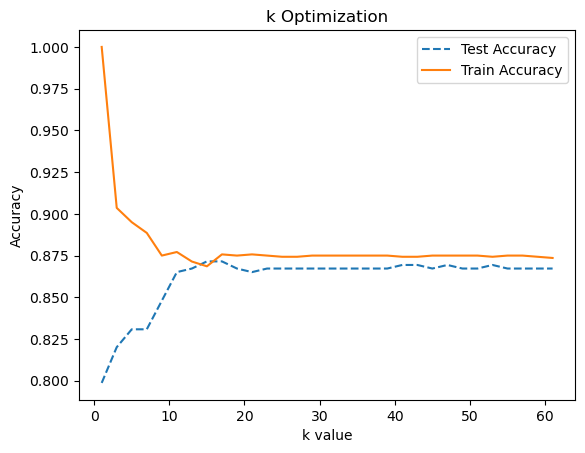

In [242]:
X,y = prepare_data()
choose_k(X,y)

Accuracy Score: 0.872

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       363
           1       0.72      0.70      0.71       104

    accuracy                           0.87       467
   macro avg       0.82      0.81      0.81       467
weighted avg       0.87      0.87      0.87       467



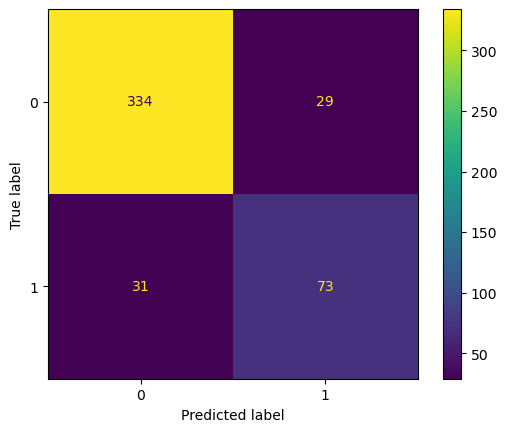

In [246]:
acc,report,conf = evaluate_prediction(X,y,15)
print('Accuracy Score: {}\n'.format(round(acc,3)))
print(report)
disp = ConfusionMatrixDisplay(confusion_matrix=conf,
                              display_labels = KNN.classes_)
disp.plot()
plt.show()

0.215
0.21627408993576017
0.892933618843683
              precision    recall  f1-score   support

           0       0.91      0.96      0.93       366
           1       0.81      0.65      0.73       101

    accuracy                           0.89       467
   macro avg       0.86      0.81      0.83       467
weighted avg       0.89      0.89      0.89       467

[[351  15]
 [ 35  66]]


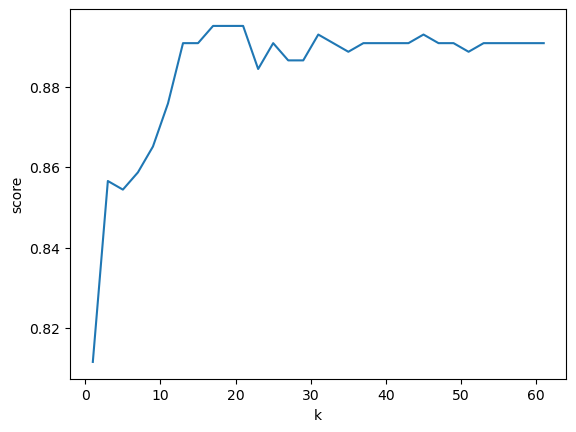

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size = 0.25,
                                                    random_state=1)



print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test))

n_samples = len(y)
kmid = int(np.sqrt(n_samples))

scores = []
kmin = 1
kmax = kmid+20
for k in range(kmin,kmax,2):
    #Train KNN
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN = KNN.fit(X_train,y_train)
    
    #Test KNN
    scores.append(KNN.score(X_test,y_test))

plt.plot(range(kmin,kmax,2),scores)
plt.ylabel('score')
plt.xlabel('k')

KNN = KNeighborsClassifier(n_neighbors=18)
KNN = KNN.fit(X_train,y_train)

y_pred = KNN.predict(X_test)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

In [232]:
from sklearn import tree
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    random_state=0)

clf = tree.DecisionTreeClassifier() # Initialize decision tree classifier
clf.fit(X_train,y_train) # Fit model to train data
ypred = clf.predict(X_test) # Use model to predict test data
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

0.6873661670235546
              precision    recall  f1-score   support

           0       0.79      0.82      0.81       372
           1       0.19      0.16      0.17        95

    accuracy                           0.69       467
   macro avg       0.49      0.49      0.49       467
weighted avg       0.67      0.69      0.68       467

[[306  66]
 [ 80  15]]
